In [160]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from skspatial.objects import LineSegment, Line, Vector

# some helper functions
from helpers import (
    get_arc_point,
    draw_arc,
    rotate,
    translate,
    flip_y,
    flip_x,
    optimize_points,
    chaikin,
    rotate_point,
    scale,
)
from pcb_json import (
    dump_json,
    plot_json,
    create_via,
    create_pad,
    create_pin,
    create_silk,
    create_silk,
    create_mounting_hole,
)

from enum import Enum

Layer = Enum("Layer", "FRONT BACK")

In [161]:
# Track width and spacing
TRACK_WIDTH = 0.127
TRACK_SPACING = 0.127

# via defaults
VIA_DIAM = 0.8
VIA_DRILL = 0.4

# this is for a 1.27mm pitch pin
PIN_DIAM = 1.0
PIN_DRILL = 0.65

# this is for the PCB connector - see https://www.farnell.com/datasheets/2003059.pdf
PAD_ENABLE = False
PAD_WIDTH = 3
PAD_HEIGHT = 2
PAD_PITCH = 2.5

# Vias for connecting to the coils
COIL_INPUT_VIAS_ENABLE = True

# PCB edge cuts
PCB_EDGE_CUTS = False

# Stator hole
STATOR_HOLE_RADIUS = 5.5

# Coil net name
COIL_NET_NAME = "coils"


In [162]:
# Standard 25 mm version

# PCB Edge size
STATOR_RADIUS = 25
STATOR_HOLE_RADIUS = 10

# where to puth the mounting pins
SCREW_HOLE_DRILL_DIAM = 2.3  # 2.3mm drill for a 2mm screw
SCREW_HOLE_RADIUS = STATOR_RADIUS

# Coil params
TURNS = 12
COIL_CENTER_RADIUS = 16
COIL_VIA_RADIUS = 17

# Coil input vias
COIL_INPUT_VIA_RADIUS = 22

In [163]:
# Large 35 mm version

# PCB Edge size
STATOR_RADIUS = 35

# where to puth the mounting pins
SCREW_HOLE_DRILL_DIAM = 2.3  # 2.3mm drill for a 2mm screw
SCREW_HOLE_RADIUS = STATOR_RADIUS

# Coil params
# for custom shape
TURNS = 16
# for spiral
# TURNS = 17
COIL_CENTER_RADIUS = 19.95
COIL_VIA_RADIUS = 20.95

# Coil input vias
COIL_INPUT_VIA_RADIUS = 27

In [164]:
# LED ring
LED_RING_ENABLE = True
LED_RING_RADIUS = 32
LED_RING_VIA_OFFSET = 2.5
LED_RING_OUTER_VIA_RADIUS = LED_RING_RADIUS + LED_RING_VIA_OFFSET
LED_RING_INNER_VIA_RADIUS = LED_RING_RADIUS - LED_RING_VIA_OFFSET
LED_CHIP_PAD_RADIAL_FROM_CENTRE = .75
LED_CHIP_PAD_ANGLE_FROM_CENTRE = -1
LED_RING_NUM_LEDS = 60
LED_PAD_ANGLE_OFFSET = 1
LED_VPLUS_NET_NAME = "V+"
LED_GND_NET_NAME = "GND"
LED_IO_NET_NAME_BASE = "LED_IO_"
LED_POWER_TRACK_WIDTH = 1.5
LED_POWER_INTERCONN_TRACK_WIDTH = 0.5
LED_INTERCONN_TO_SUPPRESS = 58

In [165]:
# where to put the input pads
INPUT_PAD_RADIUS = COIL_VIA_RADIUS
print(INPUT_PAD_RADIUS)

USE_SPIRAL = False

if USE_SPIRAL:
    TURNS = 18
    COIL_VIA_RADIUS = 20.5
    COIL_CENTER_RADIUS = 20.5

LAYERS = 8

OUTER_CONN_RADIUS = 28

20.95


# Arbitrary Coil Generation

In [166]:
# templates must be simetric around the X axis and must include the center points on both size (e.g. (X1, 0).... (X2, 0) )
# template must also be convex
template = [
    (-3.5, 0),
    (-3.5, -0.01),
    (1.9, -1.45),
    (1.9, 0.0),
    (1.9, 1.45),
    (-3.5, 0.01),
]

(-3.77, 2.17, -1.595, 1.595)

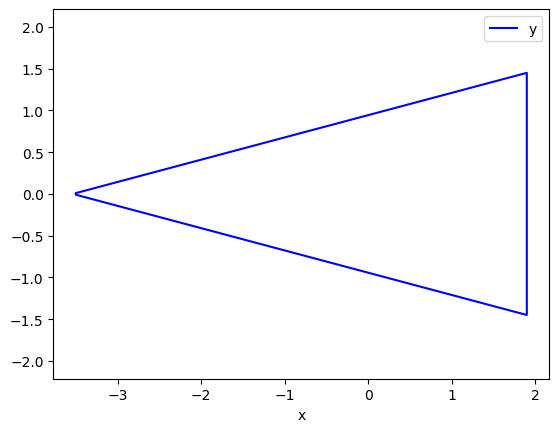

In [167]:
# plot the template shape wrapping around to the first point
df = pd.DataFrame(template + [template[0]], columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="blue")
ax.axis("equal")

In [168]:
def calculate_point(point, point1, point2, spacing, turn):
    reference_vector = Vector([-100, 0])
    angle = np.rad2deg(Vector(point).angle_between(reference_vector))
    if point[1] > 0:
        angle = 360 - angle
    vector = Vector(point1) - Vector(point2)
    normal = vector / np.linalg.norm(vector)
    # rotate the vector 90 degrees
    normal = np.array([-normal[1], normal[0]])
    # move the  point along the normal vector by the spacing
    offset = spacing * (turn * 360 + angle) / 360
    coil_point = point + normal * offset
    return (coil_point[0], coil_point[1])


def get_points(template, turns, spacing):
    coil_points = []
    reference_vector = Vector([-100, 0])
    template_index = 0
    template_length = len(template)
    for turn in range(turns * template_length):
        point1 = template[template_index % template_length]
        point2 = template[(template_index + 1) % template_length]

        # calculate the new positions of the points
        coil_point1 = calculate_point(
            point1, point1, point2, spacing, template_index // template_length
        )
        coil_point2 = calculate_point(
            point2, point1, point2, spacing, (template_index + 1) // template_length
        )
        # adjust the previous point so that the previous line intersects with this new line
        # this prevents any cutting of corners
        if len(coil_points) >= 2:
            # create a line from the previous two points
            line1 = Line(
                coil_points[len(coil_points) - 2],
                np.array(coil_points[len(coil_points) - 1])
                - np.array(coil_points[len(coil_points) - 2]),
            )
            # create a line from the two new points
            line2 = Line(
                np.array(coil_point1),
                np.array(np.array(coil_point1) - np.array(coil_point2)),
            )
            # find the intersection of the two lines
            try:
                intersection = line1.intersect_line(line2)
                # replace the previous point with the intersection
                coil_points[len(coil_points) - 1] = intersection
                # add the new point
                coil_points.append(coil_point2)
            except:
                # the lines did not intersect so just add the points
                coil_points.append(coil_point1)
                coil_points.append(coil_point2)
        else:
            coil_points.append(coil_point1)
            coil_points.append(coil_point2)

        template_index = template_index + 1
    return coil_points

In [169]:
def get_spiral(turns, start_radius, thickness, layer=Layer.FRONT):
    points = []
    # create a starting point in the center
    for angle in np.arange(0, turns * 360, 1):
        radius = start_radius + thickness * angle / 360
        if layer == Layer.BACK:
            x = radius * np.cos(np.deg2rad(angle + 180))
            y = radius * np.sin(np.deg2rad(angle + 180))
            points.append((x, -y))
        else:
            x = radius * np.cos(np.deg2rad(angle))
            y = radius * np.sin(np.deg2rad(angle))
            points.append((x, y))
    return points

In [170]:
if not USE_SPIRAL:
    print("Not using spiral")
    template_f = []
    for i in range(len(template)):
        template_f.append(template[len(template) - i - len(template) // 2])
    template_f = flip_x(template_f)
    points_f = chaikin(
        optimize_points(
            flip_x(get_points(template_f, TURNS, TRACK_SPACING + TRACK_WIDTH))
        ),
        2,
    )
    points_b = chaikin(
        optimize_points(get_points(template, TURNS, TRACK_SPACING + TRACK_WIDTH)), 2
    )
else:
    print("Using spiral")
    points_f = get_spiral(
        TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.FRONT
    )
    points_b = get_spiral(
        TURNS, VIA_DIAM / 2 + TRACK_SPACING, TRACK_SPACING + TRACK_WIDTH, Layer.BACK
    )

    points_f = [(0, 0)] + points_f
    points_b = [(0, 0)] + points_b
    print("Track points", len(points_f), len(points_b))

Not using spiral
Optimised from 128 to 66 points
Optimised from 128 to 66 points


Track points 262 262


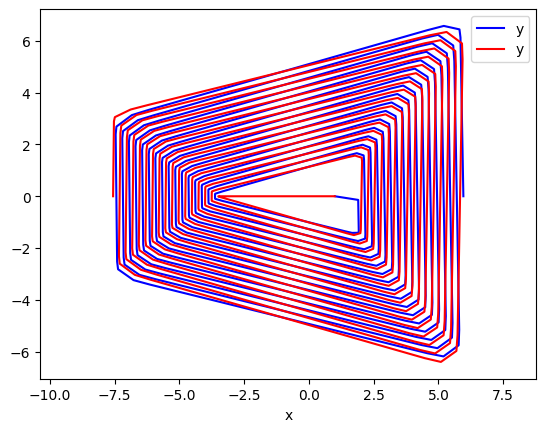

In [171]:
points_f = [(COIL_VIA_RADIUS - COIL_CENTER_RADIUS, 0)] + points_f
points_b = [(COIL_VIA_RADIUS - COIL_CENTER_RADIUS, 0)] + points_b

df = pd.DataFrame(points_f, columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="blue")
ax.axis("equal")
df = pd.DataFrame(points_b, columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="red", ax=ax)

print("Track points", len(points_f), len(points_b))

In [172]:
# write the coil out in a format that can be simulated
# rotate the points by 90 degrees so that the x axis is horizontal
pf = rotate(points_f, 90)
pb = rotate(points_b, 90)
fname = "simulations/coils/coil_12_custom"
if USE_SPIRAL:
    fname = "simulations/coils/coil_12_spiral"

# write the coil out in a format that can be simulated
p_f = rotate(points_f, 90)
p_b = rotate(points_b, 90)

with open(fname + ".csv", "w") as f:
    for point in p_f[::-1]:
        f.write(f"{point[0]},{point[1]},0,0.5\n")

# two layer board
with open(fname + "-2-layer.csv", "wt") as f:
    for point in p_f[::-1]:
        f.write(f"{point[0]},{point[1]},0,0.5\n")
    for point in p_b:
        f.write(f"{point[0]},{point[1]},0-0.062,0.5\n")

# all four layer board
with open(fname + "-4-layer.csv", "wt") as f:
    for point in p_f[::-1]:
        f.write(f"{point[0]},{point[1]},0,0.5\n")
    for point in p_b:
        f.write(f"{point[0]},{point[1]},0-0.011,0.5\n")
    for point in p_f[::-1]:
        f.write(f"{point[0]},{point[1]},0-(0.011+0.04),0.5\n")
    for point in p_b:
        f.write(f"{point[0]},{point[1]},0-(0.011+0.011+0.04),0.5\n")

In [173]:
# write the coil out in a format that can be simulated
# shift the coils aronnd to make connections a bit easier
pf = rotate(points_f, 90)
pb = rotate(points_b, 90)
fname = "simulations/coils/coil_12_custom"
if USE_SPIRAL:
    fname = "simulations/coils/coil_12_spiral"

with open(fname + ".csv", "w") as f:
    for point in pf:
        f.write(f"{point[0]/10},{point[1]/10},0,0.5\n")

# two layer board
with open(fname + "-2-layer.csv", "wt") as f:
    for point in pf[::-1]:
        f.write(f"{point[0]/10},{point[1]/10},0,0.5\n")
    for point in pb:
        f.write(f"{point[0]/10},{point[1]/10},0-0.062,0.5\n")

# all four layer board
with open(fname + "-4-layer.csv", "wt") as f:
    for point in pf[::-1]:
        f.write(f"{point[0]/10},{point[1]/10},0,0.5\n")
    for point in pb:
        f.write(f"{point[0]/10},{point[1]/10},0-0.011,0.5\n")
    for point in pf[::-1]:
        f.write(f"{point[0]/10},{point[1]/10},0-(0.011+0.04),0.5\n")
    for point in pb:
        f.write(f"{point[0]/10},{point[1]/10},0-(0.011+0.011+0.04),0.5\n")

# Generate PCB Layout

In [174]:
# calculate the total length of the track to compute the resistance
total_length_front = 0
for i in range(len(points_f) - 1):
    total_length_front += np.linalg.norm(
        np.array(points_f[i + 1]) - np.array(points_f[i])
    )
print("Total length front", total_length_front)

total_length_back = 0
for i in range(len(points_b) - 1):
    total_length_back += np.linalg.norm(
        np.array(points_b[i + 1]) - np.array(points_b[i])
    )
print("Total length back", total_length_back)

Total length front 480.66738294773955
Total length back 484.23084697358496


In [175]:
vias = []
tracks_f = []
tracks_b = []
pads = []
pins = []
mounting_holes = []
silk = []


# shift the coils around to make connections a bit easier
COIL_ROTATION = -360 / 12

coil_angles = []
for i in range(12):
    angle = i * 360 / 12 + COIL_ROTATION
    coil_angles.append(angle)

# the main coils
coil_labels = ["A", "B", "C"]
coils_f = []
coils_b = []
for i in range(12):
    angle = coil_angles[i]
    if (i // 3) % 2 == 0:
        coil_A_f = translate(rotate(points_f, angle), COIL_CENTER_RADIUS, angle)
        coil_A_b = translate(rotate(points_b, angle), COIL_CENTER_RADIUS, angle)
    else:
        # slightly nudge the coils so that they don't overlap when flipped
        coil_A_f = translate(rotate(flip_y(points_f), angle), COIL_CENTER_RADIUS, angle)
        coil_A_b = translate(rotate(flip_y(points_b), angle), COIL_CENTER_RADIUS, angle)
    # keep track of the coils
    coils_f.append(coil_A_f)
    coils_b.append(coil_A_b)

    tracks_f.append({"net":COIL_NET_NAME,"pts":coil_A_f})
    tracks_b.append({"net":COIL_NET_NAME,"pts":coil_A_b})
    vias.append(create_via(get_arc_point(angle, COIL_VIA_RADIUS), COIL_NET_NAME))
    silk.append(
        create_silk(get_arc_point(angle, COIL_CENTER_RADIUS), coil_labels[i % 3])
    )

# raidus for connecting the bottoms of the coils together
connection_radius1 = STATOR_HOLE_RADIUS + 3 * TRACK_SPACING

# create tracks to link the A coils around the center
connection_via_radius_A = connection_radius1 + 3 * TRACK_SPACING + VIA_DIAM / 2
coil_A1_A2_inner = (
    [get_arc_point(coil_angles[0], connection_via_radius_A)]
    + draw_arc(COIL_ROTATION, coil_angles[3], connection_radius1)
    + [get_arc_point(coil_angles[3], connection_via_radius_A)]
)
tracks_f.append({"net":COIL_NET_NAME,"pts":coil_A1_A2_inner})
coil_A3_A4_inner = (
    [get_arc_point(coil_angles[6], connection_via_radius_A)]
    + draw_arc(coil_angles[6], coil_angles[9], connection_radius1)
    + [get_arc_point(coil_angles[9], connection_via_radius_A)]
)
tracks_f.append({"net":COIL_NET_NAME,"pts":coil_A3_A4_inner})
# connect up the bottoms of the A coils
coils_b[0].append(coil_A1_A2_inner[0])
coils_b[3].append(coil_A1_A2_inner[-1])
coils_b[6].append(coil_A3_A4_inner[0])
coils_b[9].append(coil_A3_A4_inner[-1])
# add the vias to stitch them together
vias.append(create_via(coil_A1_A2_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_A1_A2_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_A3_A4_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_A3_A4_inner[-1], COIL_NET_NAME))

# create tracks to link the B coils around the center - this can all be done on the bottom layer
coil_B1_B2_inner = draw_arc(coil_angles[1], coil_angles[4], connection_radius1)
tracks_b.append({"net":COIL_NET_NAME,"pts":coil_B1_B2_inner})
coil_B3_B4_inner = draw_arc(coil_angles[7], coil_angles[10], connection_radius1)
tracks_b.append({"net":COIL_NET_NAME,"pts":coil_B3_B4_inner})
# connect up the bottoms of the A coils
coils_b[1].append(coil_B1_B2_inner[0])
coils_b[4].append(coil_B1_B2_inner[-1])
coils_b[7].append(coil_B3_B4_inner[0])
coils_b[10].append(coil_B3_B4_inner[-1])

# create tracks to link the C coils around the center
connection_via_radius_C = connection_via_radius_A + 3 * TRACK_SPACING + VIA_DIAM / 2
coil_C1_C2_inner = draw_arc(coil_angles[2], coil_angles[5], connection_via_radius_C)
tracks_f.append({"net":COIL_NET_NAME,"pts":coil_C1_C2_inner})
coil_C3_C4_inner = draw_arc(coil_angles[8], coil_angles[11], connection_via_radius_C)
tracks_f.append({"net":COIL_NET_NAME,"pts":coil_C3_C4_inner})
# connect up the bottoms of the B coils
coils_b[2].append(coil_C1_C2_inner[0])
coils_b[5].append(coil_C1_C2_inner[-1])
coils_b[8].append(coil_C3_C4_inner[0])
coils_b[11].append(coil_C3_C4_inner[-1])
# add the vias to stitch them together
vias.append(create_via(coil_C1_C2_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_C1_C2_inner[-1], COIL_NET_NAME))
vias.append(create_via(coil_C3_C4_inner[0], COIL_NET_NAME))
vias.append(create_via(coil_C3_C4_inner[-1], COIL_NET_NAME))

# connect the last three coils together
common_connection_radius = OUTER_CONN_RADIUS
print(common_connection_radius)
tracks_f.append({"net":COIL_NET_NAME,"pts":draw_arc(coil_angles[9], coil_angles[11], common_connection_radius)})
coils_f[9].append(get_arc_point(coil_angles[9], common_connection_radius))
coils_f[10].append(get_arc_point(coil_angles[10], common_connection_radius))
coils_f[11].append(get_arc_point(coil_angles[11], common_connection_radius))

# connect the outer A coils together
outer_connection_radius_A = OUTER_CONN_RADIUS
tracks_f.append({"net":COIL_NET_NAME,"pts":draw_arc(coil_angles[3], coil_angles[6], outer_connection_radius_A)})
coils_f[3].append(get_arc_point(coil_angles[3], outer_connection_radius_A))
coils_f[6].append(get_arc_point(coil_angles[6], outer_connection_radius_A))

# connect the outer B coils together
outer_connection_radius_B = outer_connection_radius_A - TRACK_SPACING - VIA_DIAM / 2
tracks_b.append({"net":COIL_NET_NAME,"pts":
    [get_arc_point(coil_angles[4], outer_connection_radius_B)]
    + draw_arc(coil_angles[4], coil_angles[7], outer_connection_radius_A)
    + [get_arc_point(coil_angles[7], outer_connection_radius_B)]
    }
)
coils_f[4].append(get_arc_point(coil_angles[4], outer_connection_radius_B))
coils_f[7].append(get_arc_point(coil_angles[7], outer_connection_radius_B))
vias.append(
    create_via(get_arc_point(4 * 360 / 12 + COIL_ROTATION, outer_connection_radius_B), COIL_NET_NAME)
)
vias.append(
    create_via(get_arc_point(7 * 360 / 12 + COIL_ROTATION, outer_connection_radius_B), COIL_NET_NAME)
)

# connect the outer C coilds together
outer_connection_radius_C = outer_connection_radius_B - TRACK_SPACING - VIA_DIAM / 2
tracks_b.append({"net":COIL_NET_NAME,"pts":
    draw_arc(
        5 * 360 / 12 + COIL_ROTATION,
        8 * 360 / 12 + COIL_ROTATION,
        outer_connection_radius_C,
    )
    }
)
coils_f[5].append(
    get_arc_point(5 * 360 / 12 + COIL_ROTATION, outer_connection_radius_C)
)
coils_f[8].append(
    get_arc_point(8 * 360 / 12 + COIL_ROTATION, outer_connection_radius_C)
)
vias.append(
    create_via(get_arc_point(5 * 360 / 12 + COIL_ROTATION, outer_connection_radius_C), COIL_NET_NAME)
)
vias.append(
    create_via(get_arc_point(8 * 360 / 12 + COIL_ROTATION, outer_connection_radius_C), COIL_NET_NAME)
)

#  create the pads for connecting the inputs to the coils
if PAD_ENABLE:
    silk.append(
        create_silk((INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, PAD_PITCH), "C", "b", 2.5, -900)
    )
    silk.append(create_silk((INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, 0), "B", "b", 2.5, -900))
    silk.append(
        create_silk((INPUT_PAD_RADIUS - PAD_HEIGHT - 2.5, -PAD_PITCH), "A", "b", 2.5, -900)
    )

    pads.append(create_pad((INPUT_PAD_RADIUS, -PAD_PITCH), PAD_WIDTH, PAD_HEIGHT, "b"), COIL_NET_NAME)
    pads.append(create_pad((INPUT_PAD_RADIUS, 0), PAD_WIDTH, PAD_HEIGHT, "b"), COIL_NET_NAME)
    pads.append(create_pad((INPUT_PAD_RADIUS, PAD_PITCH), PAD_WIDTH, PAD_HEIGHT, "b"), COIL_NET_NAME)

    # connect coil A to the top pad
    pad_connection_point_x = INPUT_PAD_RADIUS
    pad_angle = np.rad2deg(np.arcsin(PAD_PITCH / pad_connection_point_x))
    coils_f[0].append(get_arc_point(coil_angles[0], pad_connection_point_x))
    vias.append(create_via(get_arc_point(coil_angles[0], pad_connection_point_x), COIL_NET_NAME))
    # connect coil B to the middle pad
    coils_f[1].append((pad_connection_point_x + PAD_WIDTH / 2 + VIA_DIAM / 2, 0))
    vias.append(create_via(((pad_connection_point_x + PAD_WIDTH / 2 + VIA_DIAM / 2, 0)), COIL_NET_NAME))
    # connect coil C to the bottom pad
    coils_f[2].append(get_arc_point(coil_angles[2], pad_connection_point_x))
    vias.append(create_via(get_arc_point(coil_angles[2], pad_connection_point_x), COIL_NET_NAME))
    
elif COIL_INPUT_VIAS_ENABLE:
    
    # create vias for connecting the inputs to the coils
    for i in range(3):
        coils_f[i].append(get_arc_point(coil_angles[i], COIL_INPUT_VIA_RADIUS))
        vias.append(create_via(get_arc_point(coil_angles[i], COIL_INPUT_VIA_RADIUS), COIL_NET_NAME))


28


# Multi-Layer

In [176]:
# if we are doing multiple layers then duplicate the front and back layers
tracks_in = []
if LAYERS >= 4:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())
if LAYERS >= 6:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())
if LAYERS == 8:
    tracks_in.append(tracks_b.copy())
    tracks_in.append(tracks_f.copy())

# Led Ring

In [177]:
# LED ring wiring
if LED_RING_ENABLE:
    
    # LED wiring
    for i in range(LED_RING_NUM_LEDS):

        # Angle calculation
        angle = i * 360 / LED_RING_NUM_LEDS + COIL_ROTATION
        next_angle = (i+1) * 360 / LED_RING_NUM_LEDS + COIL_ROTATION

        # Vias for power
        vias.append(create_via(get_arc_point(angle, LED_RING_OUTER_VIA_RADIUS), LED_GND_NET_NAME))
        vias.append(create_via(get_arc_point(angle, LED_RING_INNER_VIA_RADIUS), LED_VPLUS_NET_NAME))

        # Interconnect tracks for power
        tracks_f.append({"net":LED_GND_NET_NAME,"width": LED_POWER_INTERCONN_TRACK_WIDTH,
            "pts":
            [
                get_arc_point(angle + LED_CHIP_PAD_ANGLE_FROM_CENTRE, LED_RING_RADIUS + LED_CHIP_PAD_RADIAL_FROM_CENTRE),
                get_arc_point(angle, LED_RING_OUTER_VIA_RADIUS)
            ],
            
        })
        tracks_f.append({"net":LED_VPLUS_NET_NAME,"width": LED_POWER_INTERCONN_TRACK_WIDTH,
            "pts":
            [
                get_arc_point(angle - LED_CHIP_PAD_ANGLE_FROM_CENTRE, LED_RING_RADIUS - LED_CHIP_PAD_RADIAL_FROM_CENTRE),
                get_arc_point(angle, LED_RING_INNER_VIA_RADIUS)
            ],
        })

        # Rails for power
        tracks_b.append({"net":LED_GND_NET_NAME,"width": LED_POWER_TRACK_WIDTH,
            "pts":
            [
                get_arc_point(angle, LED_RING_OUTER_VIA_RADIUS),
                get_arc_point(next_angle, LED_RING_OUTER_VIA_RADIUS)
            ],
        })
        tracks_b.append({"net":LED_VPLUS_NET_NAME,"width": LED_POWER_TRACK_WIDTH,
            "pts":
            [
                get_arc_point(angle, LED_RING_INNER_VIA_RADIUS),
                get_arc_point(next_angle, LED_RING_INNER_VIA_RADIUS)
            ],
        })

        # LED chip interconnect
        if i + 1 != LED_INTERCONN_TO_SUPPRESS:
            tracks_f.append({"net":LED_IO_NET_NAME_BASE+str(i+1),"pts":
                [
                    get_arc_point(angle - LED_CHIP_PAD_ANGLE_FROM_CENTRE, LED_RING_RADIUS + LED_CHIP_PAD_RADIAL_FROM_CENTRE),
                    get_arc_point(next_angle - LED_PAD_ANGLE_OFFSET, LED_RING_RADIUS - LED_CHIP_PAD_RADIAL_FROM_CENTRE)
                ]
            })



# Generate JSON

In [178]:
# Generate the JSON output file
if PAD_ENABLE:
    # these final bits of wiring up to the input pads don't need to be duplicated
    tracks_b.append({"net":COIL_NET_NAME,"pts":
        [(pad_connection_point_x + PAD_WIDTH / 2, 0), (pad_connection_point_x, 0)]
    }
    )
    tracks_b.append({"net":COIL_NET_NAME,"pts":draw_arc(coil_angles[0], -pad_angle, pad_connection_point_x, 1)})
    tracks_b.append({"net":COIL_NET_NAME,"pts":draw_arc(coil_angles[2], pad_angle, pad_connection_point_x, 1)})

nibble_angle_size = 360 * SCREW_HOLE_DRILL_DIAM / (2 * np.pi * STATOR_RADIUS)

if PCB_EDGE_CUTS:
    outer_cuts = (
        draw_arc(-45 + nibble_angle_size / 2, 45 - nibble_angle_size / 2, STATOR_RADIUS, 5)
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5)[::-1], 135),
            STATOR_RADIUS,
            45,
        )
        + draw_arc(
            45 + nibble_angle_size / 2, 135 - nibble_angle_size / 2, STATOR_RADIUS, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 225)[::-1],
            STATOR_RADIUS,
            135,
        )
        + draw_arc(
            135 + nibble_angle_size / 2, 225 - nibble_angle_size / 2, STATOR_RADIUS, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 315)[::-1],
            STATOR_RADIUS,
            225,
        )
        + draw_arc(
            225 + nibble_angle_size / 2, 315 - nibble_angle_size / 2, STATOR_RADIUS, 5
        )
        + translate(
            rotate(draw_arc(5, 175, SCREW_HOLE_DRILL_DIAM / 2, 5), 45)[::-1],
            STATOR_RADIUS,
            315,
        )
    )

    edge_cuts = [
        outer_cuts,
        draw_arc(0, 360, STATOR_HOLE_RADIUS, 1),
    ]
else:
    edge_cuts = [
    ]

# dump out the json version
json_result = dump_json(
    filename=f"coils_12_{STATOR_RADIUS}mm.json",
    track_width=TRACK_WIDTH,
    pin_diam=PIN_DIAM,
    pin_drill=PIN_DRILL,
    via_diam=VIA_DIAM,
    via_drill=VIA_DRILL,
    vias=vias,
    pins=pins,
    pads=pads,
    silk=silk,
    tracks_f=tracks_f,
    tracks_in=tracks_in,
    tracks_b=tracks_b,
    mounting_holes=mounting_holes,
    edge_cuts=edge_cuts,
)

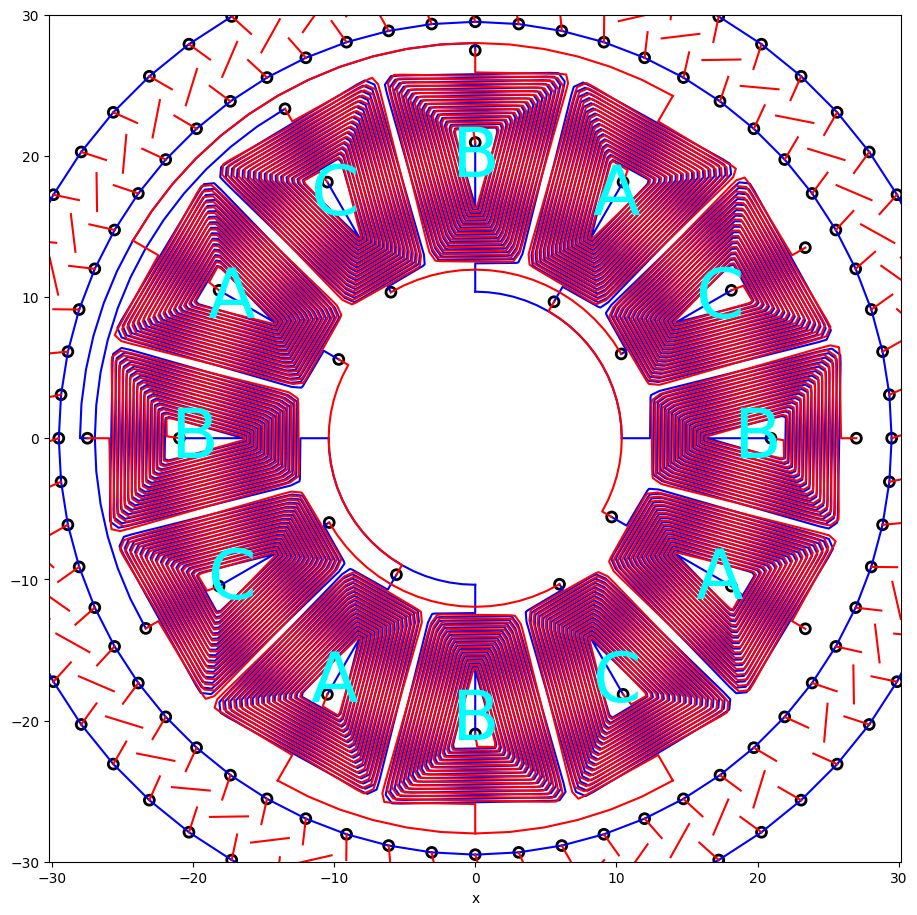

In [179]:
# plot the json
plot_json(json_result)